# CNN for Alzheimer's disease detection

The CNN is trained to detect Alzheimer's disease. Given an MRI image of the brain, the CNN can classify it in one for the following classes based on severity  
1. MildDemented
2. VeryMildDemented
3. NonDemented
4. ModerateDemeneted
   
It is trained on "Alzheimer MRI Preprocessed Dataset" dataset from [kaggle](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data) which contains total of 6400 images for 4 severity classes.

## Clone source code repository (run only on collab)

In [ ]:
! git clone https://github.com/svghadi/simple-cnn.git
%cd simple-cnn
%ls

## Import deps

In [1]:
import os, sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
import PIL 
from pathlib import Path
import random
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# for reproducibility
import torch, random, numpy as np
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Dataset

The alzheimer's dataset from kaggle is downloaded and extracted in `datasets/centralize/alherimers` folder in the source code repository. Images for each severity class are present in their individual folders. Evaluation/test data is present in a separate `datasets/evalute` folder which is a 15% of overall alzheimer's dataset from kaggle.

|Train Dataset|Evaluate Dataset|
|:-:|:-:|
![centralize_train_dataset](assets/centralize_train_dataset.png)|![evaluate dataset](assets/evaluate_dataset.png)

|Dataset Samples|
|:-:|
|![dataset samples](assets/datatset-samples.png)|


# CNN Model

In [2]:
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [3]:
from torchsummary import summary
summary(ConvNeuralNet(4), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 12, 12]          18,496
            Conv2d-5           [-1, 64, 10, 10]          36,928
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Linear-7                  [-1, 128]         204,928
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 4]             516
Total params: 271,012
Trainable params: 271,012
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.59
Params size (MB): 1.03
Estimated Total Size (MB): 1.64
-------------------------------------------

## Train & Evaluate Model

### Hyperparameters

In [4]:
# Define relevant variables for the ML task
batch_size = 32
num_classes = 4
learning_rate = 0.001

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)  

#total_step = len(train_loader)

### Load dataset

In [5]:
#data directory
train_data_dir = "./datasets/centralize/alzheimers"
test_data_dir = "./datasets/evaluate"

# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

# load dataset
train_dataset = torchvision.datasets.ImageFolder(root = train_data_dir, transform = all_transforms,)

test_dataset = torchvision.datasets.ImageFolder(root = test_data_dir, transform = all_transforms,)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

### Training

In [6]:
num_epochs = 70

loss_history = []
acc_history = []
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    epoch_loss = []
    epoch_acc = []
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log training loss & accuracy
        epoch_loss.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        epoch_acc.append(100 * correct / total)

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    avg_acc = sum(epoch_acc) / len(epoch_acc)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)
        

    print('Epoch [{}/{}], Training Loss: {:.4f}, Training Acc: {:.2f}%'.format(epoch+1, num_epochs, avg_loss, avg_acc))

Epoch [1/70], Training Loss: 1.0235, Training Acc: 51.77%
Epoch [2/70], Training Loss: 0.9306, Training Acc: 54.61%
Epoch [3/70], Training Loss: 0.9092, Training Acc: 55.98%
Epoch [4/70], Training Loss: 0.8879, Training Acc: 57.20%
Epoch [5/70], Training Loss: 0.8693, Training Acc: 58.44%
Epoch [6/70], Training Loss: 0.8619, Training Acc: 58.56%
Epoch [7/70], Training Loss: 0.8519, Training Acc: 59.54%
Epoch [8/70], Training Loss: 0.8296, Training Acc: 61.47%
Epoch [9/70], Training Loss: 0.8093, Training Acc: 62.67%
Epoch [10/70], Training Loss: 0.8144, Training Acc: 62.28%
Epoch [11/70], Training Loss: 0.7783, Training Acc: 64.20%
Epoch [12/70], Training Loss: 0.7630, Training Acc: 65.21%
Epoch [13/70], Training Loss: 0.7506, Training Acc: 66.16%
Epoch [14/70], Training Loss: 0.7084, Training Acc: 68.02%
Epoch [15/70], Training Loss: 0.6803, Training Acc: 68.72%
Epoch [16/70], Training Loss: 0.6330, Training Acc: 72.28%
Epoch [17/70], Training Loss: 0.6062, Training Acc: 73.82%
Epoch 

#### Loss vs. No. of epochs

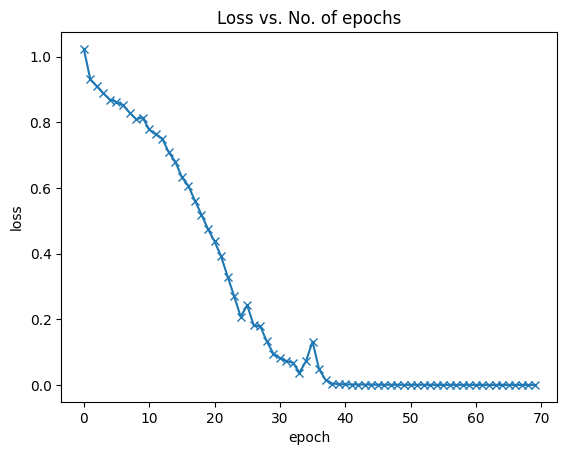

In [7]:
plt.plot(loss_history, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

#### Training Accuracy vs. No. of epochs

Text(0.5, 1.0, 'Training Accuracy vs. No. of epochs')

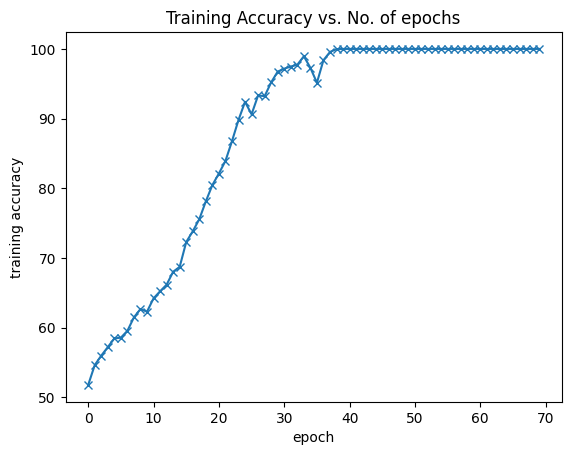

In [8]:
plt.plot(acc_history, '-x')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.title('Training Accuracy vs. No. of epochs')

### Testing

In [9]:
train_acc = 0
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print('Accuracy of the network on unseen {} images: {:.2f} %'.format(len(test_loader.dataset), train_acc))


Accuracy of the network on unseen 918 images: 94.77 %


### Log model accuracy

In [10]:
import pickle 
from prettytable import PrettyTable

aggr_results={}
try: 
    with open('reports/aggr_results.pkl', 'rb') as f:
        aggr_results = pickle.load(f)
except Exception as e:
    print(e)
    aggr_results={}
    
with open('reports/aggr_results.pkl', 'wb') as f:
    aggr_results["Centralize"] = {
        "avg_test_acc": train_acc,
        }
    pickle.dump(aggr_results, f)
    
table = PrettyTable()
table.field_names = ["Aggr", "Test Acc %"]
for k,v in aggr_results.items():
    table.add_row([k, "{:.2f}".format(v["avg_test_acc"])])
print(table)
with open('reports/aggr_results_table.txt', 'w') as f:
    f.write(table.get_string())

[Errno 2] No such file or directory: 'reports/aggr_results.pkl'
+------------+------------+
|    Aggr    | Test Acc % |
+------------+------------+
| Centralize |   94.77    |
+------------+------------+
